<a href="https://colab.research.google.com/github/divaamahajan/logAnalysis-kafka-spark/blob/main/NASAlogs/log_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable Web Server Log Analytics with Apache Spark


# Setting up Dependencies

In [1]:
!pip install spark
!pip install pyspark
!pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58747 sha256=dc7ffd3b361dc54026020bcbb1f94485c85a25f0d26dab5ae3e04d1ba1e8c62d
  Stored in directory: /root/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=842a4ebc846562fb43c9f182d8fe7cb4ceaea265405d44e63daa326fcd0791da
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully

In [5]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession

# Get the existing SparkSession
spark = SparkSession.builder.getOrCreate()

# Create SQLContext
sqlContext = SQLContext(spark)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
spark

In [7]:
sqlContext

In [8]:
import re
import pandas as pd

## Basic Regular Expressions

In [9]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<re.Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<re.Match object; span=(25, 36), match=' in PySpark'> 25 36


- Jul 01 to Jul 31, ASCII format, 20.7 MB gzip compressed, 205.2 MB uncompressed: [ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz](ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz)
- Aug 04 to Aug 31, ASCII format, 21.8 MB gzip compressed, 167.8 MB uncompressed: [ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz](ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz)

Make sure both the files are in the same directory as this notebook.

# Loading and Viewing the NASA Log Dataset

This will produce a DataFrame with a single string column called `value`.

In [10]:
import glob

raw_data_files = glob.glob('*.gz')
raw_data_files

['NASA_access_log_Aug95.gz', 'NASA_access_log_Jul95.gz']

### Metadata of dataframe

In [11]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [12]:
type(base_df)

pyspark.sql.dataframe.DataFrame

Convert a dataframe to an RDD if needed

In [13]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

### Viewing sample data in our dataframe

In [14]:
base_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

In [15]:
base_df_rdd.take(10)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

# Data Wrangling
Clean and parse dataset to extract structured attributes with meaningful information from each log message.


## Data Parsing and Extraction with Regular Expressions


In [81]:
print((base_df.count(), len(base_df.columns)))

(3461613, 1)


Sample log messages

In [82]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

### Extracting host names


In [83]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

### Extracting timestamps 

In [84]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:15 -0400',
 '01/Jul/1995:00:00:15 -0400']

### Extracting HTTP Request Method, URIs and Protocol 

In [85]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/history/apollo/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/KSC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0')]

### Extracting HTTP Status Codes


In [86]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


### Extracting HTTP Response Content Size

In [87]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074', '40310', '786', '1204', '40310', '786']


## Log Extraction (putting it all together)

In [88]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

## Finding Missing Values

In [89]:
(base_df
    .filter(base_df['value']
                .isNull())
    .count())

0

We should not have any rows with potential null values

In [90]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33905

__Note:__ :  _big dataset_ is residing on disk which can potentially be present in multiple nodes in a spark cluster.

### Finding Null Counts


In [91]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [92]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



- One missing value in the `status` column 
- rest 33905 missing value is in the `content_size` column. 

### Handling nulls in HTTP status


In [93]:
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

1

In [94]:
null_status_df.show(truncate=False)

+--------+
|value   |
+--------+
|alyssa.p|
+--------+



In [95]:
bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|    |         |      |        |        |null  |null        |
+----+---------+------+--------+--------+------+------------+



Drop this record.

In [96]:
logs_df.count()

3461613

In [97]:
logs_df = logs_df[logs_df['status'].isNotNull()] 
logs_df.count()

3461612

In [98]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



### Handling nulls in HTTP content size


#### Find out the records in our base data frame with potential missing content sizes

In [99]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

33905

### Display the top ten records of data frame having missing content sizes

In [100]:
null_content_size_df.take(10)

[Row(value='dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -'),
 Row(value='dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:03:24 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='link097.txdirect.net - - [01/Jul/1995:00:05:06 -0400] "GET /shuttle HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:13 -0400] "GET /shuttle/missions/sts-78/news HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:58 -0400] "GET /shuttle/missions/sts-72/news HTTP/1.0" 302 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:19 -0400] "GET /pub/winvn/readme.txt HTTP/1.0" 404 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:28 -0400] "GET

The bad raw data records correspond to error responses, where no content was sent back and the server emitted a "`-`" for the `content_size` field. Let's impute or fill them to 0.

#### Fix the rows with null content\_size

In [101]:
logs_df = logs_df.na.fill({'content_size': 0})

In [102]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



## Handling Temporal Fields (Timestamp)

Parse the timestamp field into an actual timestamp.

In [103]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [104]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400']

In [105]:
[parse_clf_time(item) for item in sample_ts]

['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

In [106]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('datetime')).drop('timestamp')
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|           datetime|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [107]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second, date_format, count, max

# Extract the day of the week from the timestamp column
logs_df = logs_df.withColumn('day_of_week', date_format(logs_df.datetime, 'EEEE'))

# Add columns for year, month, and date
logs_df = logs_df.withColumn('year', year(logs_df['datetime']))
logs_df = logs_df.withColumn('month', month(logs_df['datetime']))
logs_df = logs_df.withColumn('date', dayofmonth(logs_df['datetime']))

# Add columns for hour, minute, and second
logs_df = logs_df.withColumn('hour', hour(logs_df['datetime']))
logs_df = logs_df.withColumn('minute', minute(logs_df['datetime']))
logs_df = logs_df.withColumn('second', second(logs_df['datetime']))

# Show the updated DataFrame
logs_df.show(10, truncate=True)


+--------------------+------+--------------------+--------+------+------------+-------------------+-----------+----+-----+----+----+------+------+
|                host|method|            endpoint|protocol|status|content_size|           datetime|day_of_week|year|month|date|hour|minute|second|
+--------------------+------+--------------------+--------+------+------------+-------------------+-----------+----+-----+----+----+------+------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|   Saturday|1995|    7|   1|   0|     0|     1|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|   Saturday|1995|    7|   1|   0|     0|     6|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|   Saturday|1995|    7|   1|   0|     0|     9|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|   Saturday|1995|  

In [108]:
logs_df.select('year').distinct().rdd.flatMap(lambda x: x).collect()


[1995]

In [109]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- datetime: timestamp (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)



In [110]:
logs_df.limit(5).toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,host,method,endpoint,protocol,status,content_size,datetime,day_of_week,year,month,date,hour,minute,second
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01,Saturday,1995,7,1,0,0,1
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06,Saturday,1995,7,1,0,0,6
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09,Saturday,1995,7,1,0,0,9
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11,Saturday,1995,7,1,0,0,11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11,Saturday,1995,7,1,0,0,11


Let's now cache `logs_df` since we will be using it extensively for our data analysis section in the next part!

In [111]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, datetime: timestamp, day_of_week: string, year: int, month: int, date: int, hour: int, minute: int, second: int]

# Data Analysis on Web Logs (EDA)

Exploratory data analysis (EDA)


## Content Size Statistics

In [112]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949228
3,min,0
4,max,6823936


In [113]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,18928.844398,73031.472609,3461612


## HTTP Status Code Analysis


In [114]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

In [115]:
print('Total distinct HTTP Status Codes:', status_freq_df.count())

Total distinct HTTP Status Codes: 8


In [116]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,3100524
2,304,266773
1,302,73070
5,404,20899
4,403,225
6,500,65
7,501,41
3,400,15


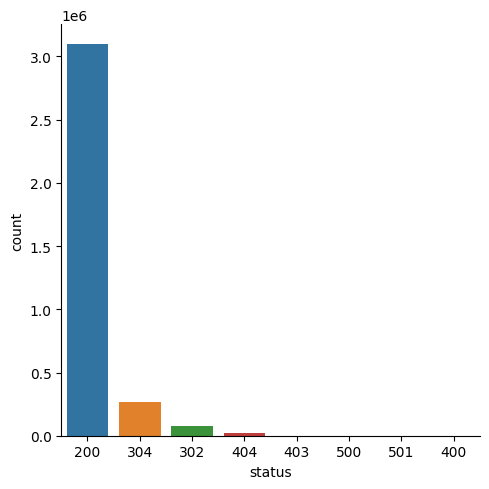

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [118]:
log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   200|3100524|14.947081687429097|
|   302|  73070|11.199173164785263|
|   304| 266773|12.494153388502301|
|   400|     15|  2.70805020110221|
|   403|    225|  5.41610040220442|
|   404|  20899| 9.947456589918252|
|   500|     65| 4.174387269895637|
|   501|     41| 3.713572066704308|
+------+-------+------------------+



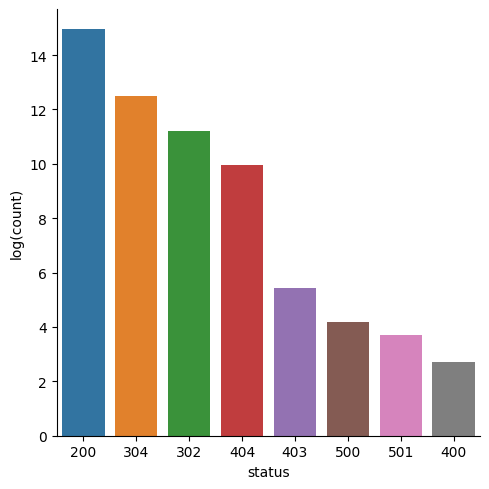

In [119]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

## Analyzing Frequent Hosts
Get the count of total accesses by each `host` and then sort by the counts and display only the top ten most frequent hosts.

In [120]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+



In [121]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[8]['host']

''

Note: check for potentially empty strings when data wrangling.

## Display the Top 20 Frequent EndPoints
The number of hits to endpoints (URIs) in the log. 
- Group by the `endpoint` column, aggregate by count, 
- sort in descending order like the previous part.

In [122]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

In [123]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/images/NASA-logosmall.gif,208714
1,/images/KSC-logosmall.gif,164970
2,/images/MOSAIC-logosmall.gif,127908
3,/images/USA-logosmall.gif,127074
4,/images/WORLD-logosmall.gif,125925
5,/images/ksclogo-medium.gif,121572
6,/ksc.html,83909
7,/images/launch-logo.gif,76006
8,/history/apollo/images/apollo-logo1.gif,68896
9,/shuttle/countdown/,64736


## Top 10 Error Endpoints
Sorted list containing the endpoints and the number of times that they were accessed with a non-200 return code and show the top ten.

In [124]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

In [125]:
error_endpoints_freq_df.show(truncate=False)

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



## Total number of Unique Hosts

In [126]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

137933

## Number of Unique Daily Hosts


In [136]:
# host_day_df = logs_df.select(logs_df.host, 
#                              F.dayofmonth('datetime').alias('day'))
host_day_distinct_df = logs_df.select(logs_df.host,'date').dropDuplicates()
host_day_distinct_df.show(5, truncate=False)

+-----------------------+----+
|host                   |date|
+-----------------------+----+
|129.94.144.152         |1   |
|slip1.yab.com          |1   |
|205.184.190.47         |1   |
|204.120.34.71          |1   |
|ppp3_130.bekkoame.or.jp|1   |
+-----------------------+----+
only showing top 5 rows



**`daily_unique_hosts_df`**

A DataFrame with two columns:

| column  | explanation                                        |
| ------- | -------------------------------------------------- |
| `day`   | the day of the month                               |
| `count` | the number of unique requesting hosts for that day |

In [137]:
dir(pd.options)

['compute', 'display', 'io', 'mode', 'plotting', 'styler']

In [139]:
def_mr = pd.options.display.max_rows
pd.options.display.max_rows = 10
daily_hosts_df = (host_day_distinct_df
                     .groupBy('date')
                     .count()
                     .sort("date"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,date,count
0,1,7609
1,2,4858
2,3,10238
3,4,9411
4,5,9640
...,...,...
26,27,6846
27,28,6090
28,29,4825
29,30,5265


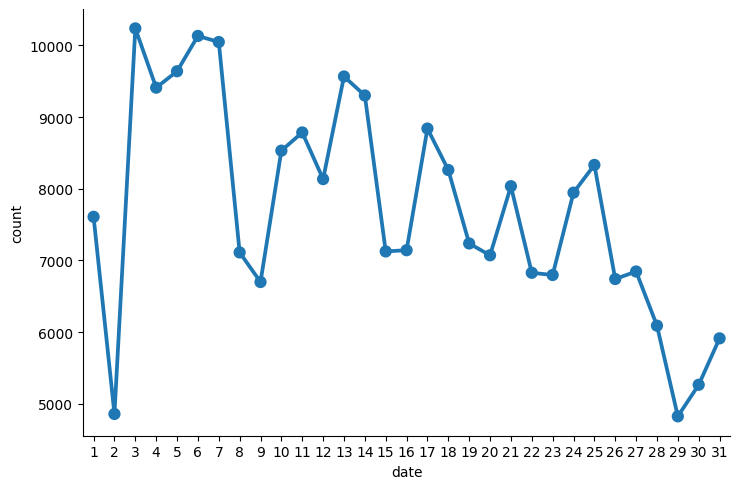

In [140]:
c = sns.catplot(x='date', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)

## Average Number of Daily Requests per Host
- DataFrame sorted by increasing day of the month which includes the day of the month 
- the associated number of average requests made for that day per Host. 

In [142]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('date')
                     .count()
                     .select(col('date'), 
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select("date")
                              .groupBy('date')
                              .count()
                              .select(col("date"), 
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'date')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("date"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,date,total_reqs,total_hosts,avg_reqs
0,1,98710,7609,12.972795
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
...,...,...,...,...
26,27,94503,6846,13.804119
27,28,82617,6090,13.566010
28,29,67988,4825,14.090777
29,30,80641,5265,15.316429


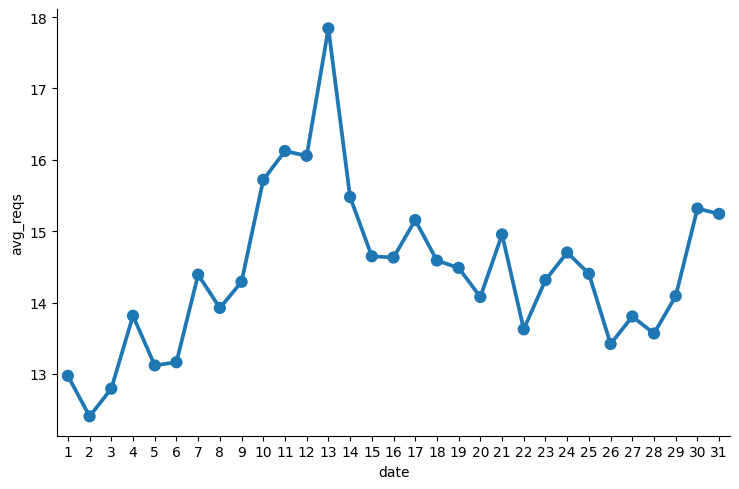

In [143]:
c = sns.catplot(x='date', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

## Counting 404 Response Codes


In [144]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 20899


## Listing the Top Twenty 404 Response Code Endpoints


In [145]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |683  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |428  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

## Listing the Top Twenty 404 Response Code Hosts


In [146]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|www-b4.proxy.aol.com       |62   |
|dialip-217.den.mmc.com     |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|piweba2y.prodigy.com       |59   |
|www-d2.proxy.aol.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



## Visualizing 404 Errors per Day


In [147]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy("date")
                                .count()
                                .sort("date"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,date,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
...,...,...
26,27,706
27,28,504
28,29,420
29,30,571


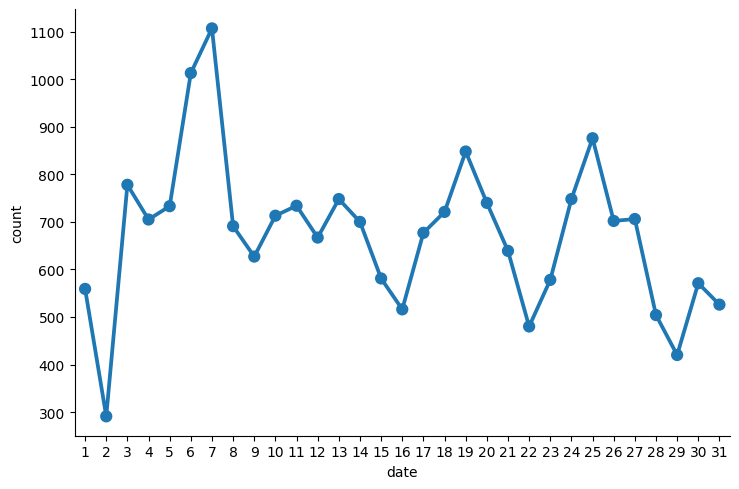

In [148]:
c = sns.catplot(x='date', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

## Top Three Days for 404 Errors


In [149]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+----+-----+
|date|count|
+----+-----+
|   7| 1107|
|   6| 1013|
|  25|  876|
+----+-----+
only showing top 3 rows



## Visualizing Hourly 404 Errors

In [151]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy('hour')
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

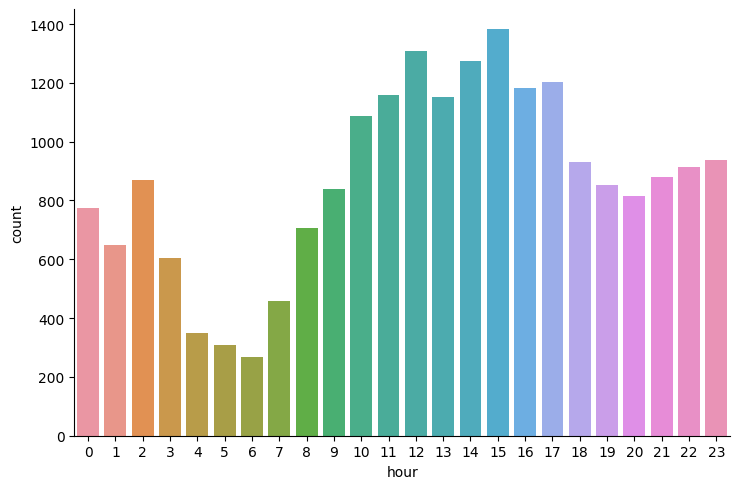

In [152]:
c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)

### Reset the max rows displayed in pandas

In [153]:
pd.set_option('display.max_rows', def_mr)



## Top 10 years in which there are least 404 status codes

In [155]:
from pyspark.sql.functions import col

# Group by year and count the occurrences
year_counts_df = not_found_df.groupBy('year').count()

# Sort the DataFrame in ascending order
year_counts_df = year_counts_df.sort(col('count').asc())

# Show the top 10 records
year_counts_df.show(10)


+----+-----+
|year|count|
+----+-----+
|1995|20899|
+----+-----+



## Days of the Week with the Least 404 Status Codes

In [185]:
from pyspark.sql.functions import col

week_counts_df = not_found_df.groupBy('day_of_week').count().orderBy(col('count').asc())
week_counts_df.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|   Saturday| 2069|
|     Sunday| 2400|
|     Friday| 2691|
|     Monday| 3145|
|  Wednesday| 3397|
|    Tuesday| 3425|
|   Thursday| 3772|
+-----------+-----+



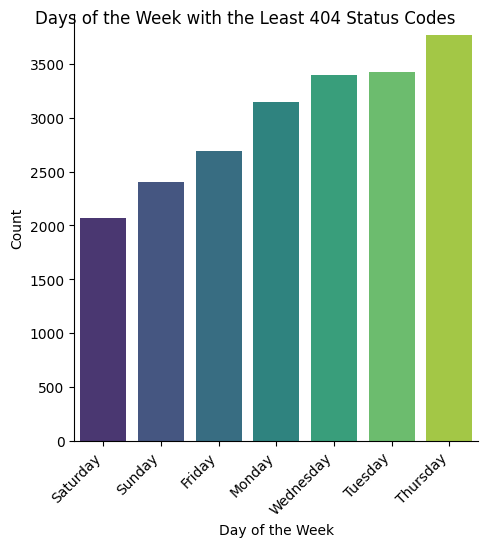

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a pandas DataFrame
week_counts_pd = week_counts_df.toPandas()

# Define a color palette
colors = sns.color_palette('viridis', len(week_counts_pd))

# Plot the data using sns.catplot with customized colors
plot = sns.catplot(x='day_of_week', y='count', kind='bar', data=week_counts_pd, palette=colors)

# Set labels and title
plot.set(xlabel='Day of the Week', ylabel='Count')
plot.fig.suptitle('Days of the Week with the Least 404 Status Codes')

# Rotate the x-axis labels diagonally
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

## Endpoint that received the highest number of invocations on a specific day of the week

Calculating the count of invocations for each unique combination of day of the week and endpoint

In [170]:
from pyspark.sql.functions import date_format, count, max
# Group the data by day of the week and endpoint, and count the number of invocations
grouped_df = logs_df.groupBy('day_of_week', 'endpoint').agg(count('*').alias('invocations'))
grouped_df.show(10, truncate=True)


+-----------+--------------------+-----------+
|day_of_week|            endpoint|invocations|
+-----------+--------------------+-----------+
|   Saturday|/images/vab-small...|        333|
|   Saturday|/cgi-bin/imagemap...|          6|
|   Saturday|/cgi-bin/imagemap...|          4|
|   Saturday|/shuttle/technolo...|        611|
|   Saturday|/cgi-bin/imagemap...|          1|
|   Saturday|/cgi-bin/imagemap...|          1|
|   Saturday|/history/apollo/a...|         35|
|   Saturday|/software/winvn/u...|          2|
|   Saturday|     /icons/back.xbm|          5|
|   Saturday|/history/apollo/a...|         56|
+-----------+--------------------+-----------+
only showing top 10 rows



Select the highest count for each unique day of week

In [172]:
# Avoids the join operation. 
# Utilize window functions to rank the rows and directly filter the rows with the highest invocations.
# This can be advantageous when dealing with large datasets since it avoids the overhead of the join operation.

from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

# Add a row number column based on the invocations in descending order for each day_of_week
windowSpec = Window.partitionBy('day_of_week').orderBy(grouped_df['invocations'].desc())
ranked_df = grouped_df.withColumn('rank', row_number().over(windowSpec))

# Filter the ranked DataFrame to retain only the rows with rank 1 (highest invocations)
max_invocations_df = ranked_df.filter(ranked_df['rank'] == 1)

# Summarize the results and display the day_of_week, endpoint, and invocations with max invocations
max_invocations_df.select('day_of_week', 'endpoint', 'invocations').show()

+-----------+--------------------+-----------+
|day_of_week|            endpoint|invocations|
+-----------+--------------------+-----------+
|     Friday|/images/NASA-logo...|      29139|
|     Monday|/images/NASA-logo...|      30380|
|   Saturday|/images/NASA-logo...|      16168|
|     Sunday|/images/KSC-logos...|      15218|
|   Thursday|/images/NASA-logo...|      46920|
|    Tuesday|/images/NASA-logo...|      33685|
|  Wednesday|/images/NASA-logo...|      37598|
+-----------+--------------------+-----------+



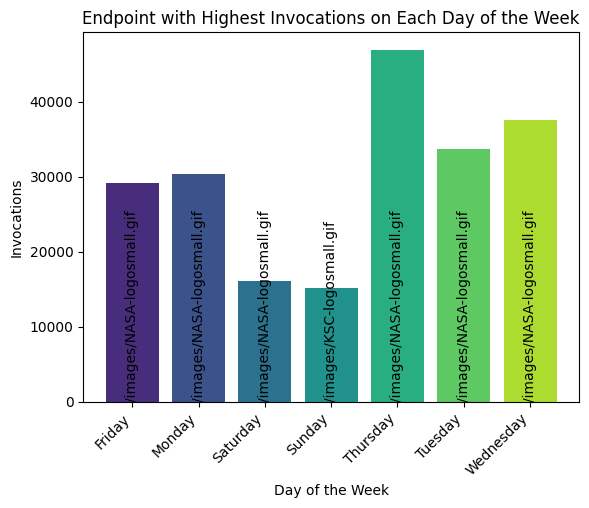

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the data from the DataFrame
days_of_week = max_invocations_df.select('day_of_week').rdd.flatMap(lambda x: x).collect()
endpoints = max_invocations_df.select('endpoint').rdd.flatMap(lambda x: x).collect()
invocations = max_invocations_df.select('invocations').rdd.flatMap(lambda x: x).collect()

# Create the bar plot with colorful bars
fig, ax = plt.subplots()
bars = ax.bar(days_of_week, invocations, color=sns.color_palette('viridis', len(days_of_week)))
plt.xlabel('Day of the Week')
plt.ylabel('Invocations')
plt.title('Endpoint with Highest Invocations on Each Day of the Week')

# Annotate the bars with the corresponding endpoints
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, 2,  # Set y-coordinate to 2
            endpoints[i], ha='center', va='bottom', rotation=90)

# Rotate the x-labels diagonally
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [ ]:

# from pyspark.sql.functions import col, max

# # Find the maximum invocations for each day_of_week
# max_invocations_df = grouped_df.groupBy('day_of_week').agg(max('invocations').alias('max_invocations'))

# # Join the original DataFrame with the maximum invocations to get the corresponding endpoint
# result_df = grouped_df.join(max_invocations_df, 'day_of_week', 'inner') \
#     .filter(col('invocations') == col('max_invocations')) \
#     .select('day_of_week', 'endpoint', 'max_invocations')

# # Summarize the results and display the day_of_week, endpoint, and invocations with max invocations
# result_df.show()
